In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
import scipy.stats as sp
from scipy.stats import median_abs_deviation, skew, kurtosis
from scipy.stats import norm, logistic, laplace
from scipy.stats import pearsonr
from scipy.special import erf
import seaborn as sns; sns.set()

# MIEDŹ

## Ceny miedzi na przestrzeni 5 lat (Open) (cena za nie wiem jaką ilość)

In [65]:
copper_ = pd.read_csv('../data/copper.csv', sep = ',', encoding = 'latin-1')
copper_

,Date,Close/Last,Volume,Open,High,Low
0,04/14/2023,4.1065,98124,4.1285,4.1955,4.0950
1,04/13/2023,4.1240,88437,4.0700,4.1430,4.0535
2,04/12/2023,4.0810,88325,4.0295,4.0880,3.9840
3,04/11/2023,4.0195,81243,3.9870,4.0540,3.9780
4,04/10/2023,3.9765,53745,4.0180,4.0395,3.9630
...,...,...,...,...,...,...
1255,04/20/2018,3.1555,33960,3.1490,3.1685,3.1275
1256,04/19/2018,3.1540,37634,3.1835,3.2180,3.1350
1257,04/18/2018,3.1815,51721,3.1100,3.2015,3.0995
1258,04/17/2018,3.0795,88784,3.0835,3.1020,3.0545


In [66]:
def equalize(df): #funkcja ta skaluje ceny miedzi do cen za tonę
    d = 2204.623
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

In [67]:
copper = equalize(copper_)
copper

,Date,Close/Last,Volume,Open,High,Low
0,04/14/2023,9053.284349,98124,9101.786056,9249.495796,9027.931185
1,04/13/2023,9091.865252,88437,8972.815610,9133.753089,8936.439330
2,04/12/2023,8997.066463,88325,8883.528378,9012.498824,8783.218032
3,04/11/2023,8861.482148,81243,8789.831901,8937.541642,8769.990294
4,04/10/2023,8766.683360,53745,8858.175214,8905.574609,8736.920949
...,...,...,...,...,...,...
1255,04/20/2018,6956.687877,33960,6942.357827,6985.347975,6894.958432
1256,04/19/2018,6953.380942,37634,7018.417320,7094.476814,6911.493105
1257,04/18/2018,7014.008075,51721,6856.377530,7058.100534,6833.228989
1258,04/17/2018,6789.136529,88784,6797.955020,6838.740546,6734.020954


In [68]:
def draw_stock(df, clr):
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.show()

## Wykres cen miedzi

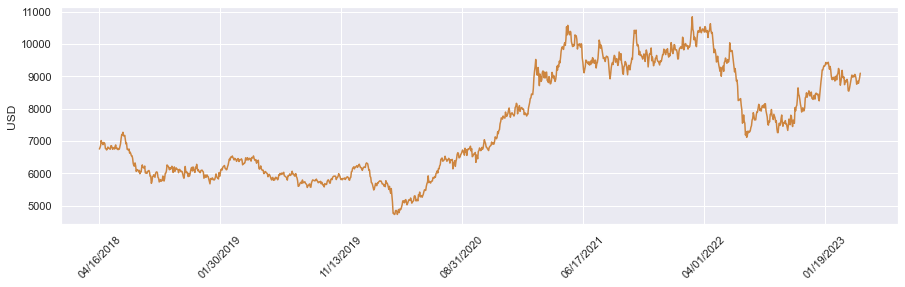

In [69]:
draw_stock(copper, 'peru')

## Histogram logarytmicznych przyrostów

In [70]:
def draw_ret(df, clr):
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1][:-1]
    prices1 = df['Open'].values[::-1][1:]
    prices2 = df['Open'].values[::-1][:-1]
    r = prices1/prices2
    plt.plot(dates, r, color = clr)
    plt.ylabel('USD')
    plt.show()

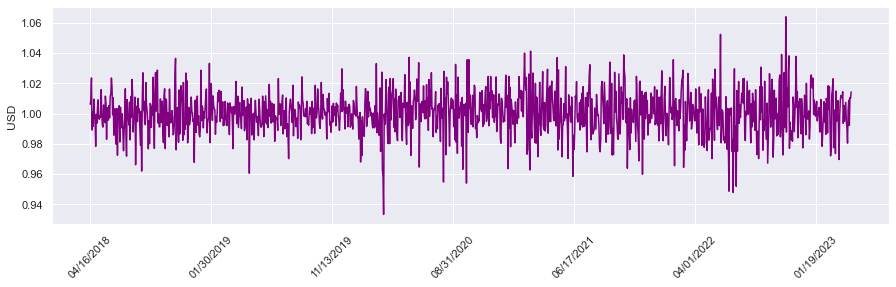

In [71]:
s = np.array(copper['Open'].values[1:])
s2 = np.array(copper['Open'].values[:-1])
r = np.log(s/s2)
draw_ret(copper, 'purple')

## Miary ryzyka

In [72]:
print('Średnia: ' + str(np.mean(r)))
print('Wariancja: ' + str(np.var(r)))
print('Skośność: ' + str(skew(r)))
print('Kurtoza: ' + str(kurtosis(r)))
print('Odchylenie standardowe: ' + str(stdev(r)))
print('Odchylenie przeciętne: ' + str(median_abs_deviation(r)))
print('Pierwszy kwartyl: ' + str(np.quantile(r, .25)))
print('Mediana: ' + str(np.quantile(r, .5)))
print('Trzeci kwartyl: ' + str(np.quantile(r, .75)))
print('Odchylenie ćwiartkowe: ' + str(0.5*(np.quantile(r, .75) - np.quantile(r, .25))))

Średnia: -0.0002367193970863344
Wariancja: 0.00020321096766212561
Skośność: 0.17440041345123358
Kurtoza: 1.184339957347377
Odchylenie standardowe: 0.014260873136402709
Odchylenie przeciętne: 0.008379502169224238
Pierwszy kwartyl: -0.00903230848294452
Mediana: -0.0001925113106339907
Trzeci kwartyl: 0.007855416857546486
Odchylenie ćwiartkowe: 0.008443862670245503


In [73]:
mu = np.mean(r)
s = stdev(r)

## Porównanie kwantyli (parametryczne i nieparametryczne) 95%, 97.5% i 99%

In [74]:
#Porównanie histogramu z wykresami funkcji gęstości
def norm_kde(x, best_fit = None, bin_no = 50):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.array(sorted(x))
    mi = np.mean(x)
    sigma = stdev(x)
    
    plt.hist(x, bins = bin_no, density = True, color = 'white', ec = 'black')
    y = norm.pdf(x, mi, sigma) #rozkład normalny
    plt.plot(x, y, color = 'blue', label = 'normal pdf')
    if best_fit == logistic:
        y2 = logistic.pdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
        plt.plot(x, y2, color = 'red', label = 'logistic pdf')
    if best_fit == laplace:
        y2 = laplace.pdf(x, mi, 1/np.sqrt(2) * sigma)
        plt.plot(x, y2, color = 'red', label = 'laplace pdf')   
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

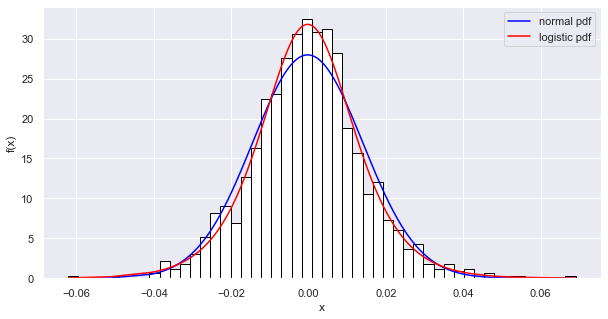

In [75]:
norm_kde(r, logistic)

In [76]:
def comp_quantile(x, p1, p2, p3): #p ma być z zakresu [0, 1]
    mi = np.mean(x)
    sigma = stdev(x)
    p = [p1, p2, p3]
    real = np.quantile(x, p)
    nrm = norm.ppf(p, mi, sigma)
    lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)
    perc = [format(p, '.2%') for p in [p1, p2, p3]]
    dct = {'p' : perc, 'real' : real, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

In [77]:
comp_quantile(r, .95, .975, .99)

,p,real,normal,logistic
0,95.00%,0.023471,0.023220,0.022914
1,97.50%,0.028709,0.027714,0.028568
2,99.00%,0.037609,0.032939,0.035892


## Wartości dystrybuanty

In [78]:
#Porównanie dystrybuant teoretycznych z dystrybuantą empiryczną
def cdf(x, best_fit = None):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.array(sorted(x))
    mi = np.mean(x)
    sigma = stdev(x)
    
    sns.ecdfplot(data = x, color = 'blue', label = 'ECDF', linestyle = 'dashdot')
    y = norm.cdf(x, mi, sigma)
    plt.plot(x, y, color = 'black', label = 'norm cdf', lw = .7)

    if best_fit == logistic:
        y2 = logistic.cdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
        plt.plot(x, y2, color = 'red', label = 'logistic cdf', lw = .7)
    if best_fit == laplace:
        y2 = laplace.cdf(x, mi, 1/np.sqrt(2) * sigma)
        plt.plot(x, y2, color = 'red', label = 'laplace cdf', lw = .7)   

    plt.xlabel('x')
    plt.ylabel('F(x)')
    plt.legend()
    plt.show()

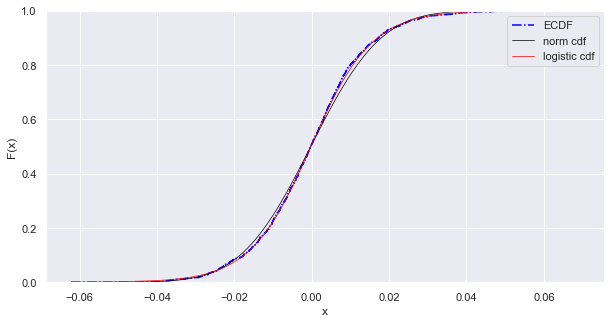

In [79]:
cdf(r, logistic)

Sprawdzimy wartości dystrybuant dla $x \in \{-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05\}$

In [80]:
def comp_dist(x, x0 = [-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05]):
    x = sorted(x)
    mi = np.mean(x)
    sigma = stdev(x)
#     real = [np.linspace(0, 1, len(x))]
    nrm = norm.cdf(x0, mi, sigma)
    lgstc = logistic.cdf(x0, mi, sigma)
    dct = {'x0' : x0, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

In [81]:
comp_dist(r)

,x0,normal,logistic
0,-0.05,0.000242,0.029613
1,-0.03,0.018441,0.110361
2,-0.01,0.246792,0.335231
3,0.00,0.506622,0.504150
4,0.01,0.763565,0.672126
5,0.03,0.983008,0.892857
6,0.05,0.999786,0.971327


## Miary wrażliwości

# ALUMINIUM (jeszcze do uzgodnienia)

## Ceny aluminium (Open) (w USD za tonę)

In [82]:
aluminium = pd.read_csv('../data/aluminium.csv', sep = ',', encoding = 'latin-1')
aluminium

,Date,Close/Last,Volume,Open,High,Low
0,04/12/2023,2328.50,1205.0,2311.00,2335.0,2293.50
1,04/11/2023,2306.75,1979.0,2333.75,2335.5,2302.50
2,04/10/2023,2348.00,2215.0,2348.00,2348.0,2348.00
3,04/06/2023,2338.25,1373.0,2355.00,2359.5,2329.25
4,04/05/2023,2370.00,NaN,2370.00,2370.0,2370.00
...,...,...,...,...,...,...
1254,04/19/2018,2300.00,NaN,2300.00,2300.0,2300.00
1255,04/18/2018,2300.00,NaN,2300.00,2300.0,2300.00
1256,04/17/2018,2300.00,NaN,2300.00,2300.0,2300.00
1257,04/16/2018,2300.00,NaN,2300.00,2300.0,2300.00


In [83]:
type(aluminium.Date.values[0])

str

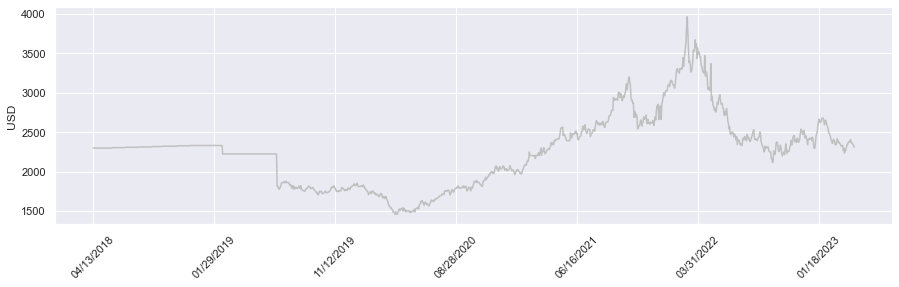

In [84]:
draw_stock(aluminium, 'silver')

In [85]:
idx = aluminium.index[aluminium['Date'] == '07/01/2019'].tolist()[0]
idx

952

In [86]:
aluminium2 = aluminium.drop(aluminium.index[idx:1259])

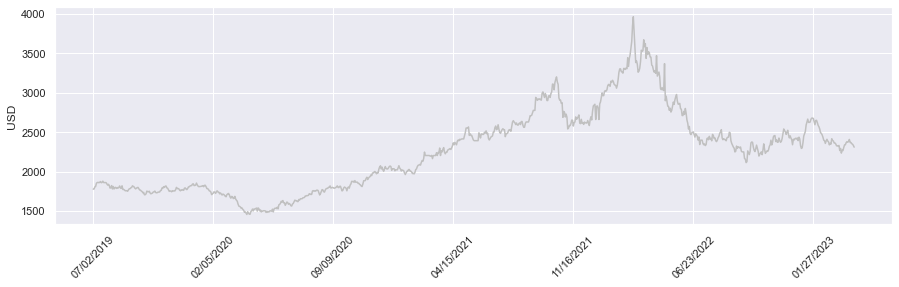

In [87]:
draw_stock(aluminium2, 'silver')

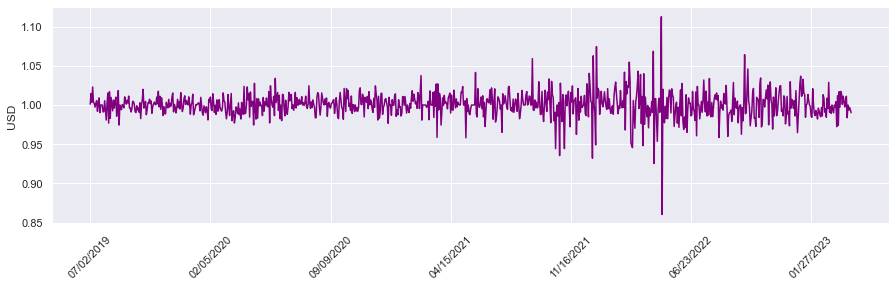

In [88]:
#logarytmiczne stopy zwrotu
s_ = np.array(aluminium2['Open'].values[1:])
s2_ = np.array(aluminium2['Open'].values[:-1])
r2 =  np.log(s_/s2_)
draw_ret(aluminium2, 'purple')

In [89]:
print('Średnia: ' + str(np.mean(r2)))
print('Wariancja: ' + str(np.var(r2)))
print('Skośność: ' + str(skew(r2)))
print('Kurtoza: ' + str(kurtosis(r2)))
print('Odchylenie standardowe: ' + str(stdev(r2)))
print('Odchylenie przeciętne: ' + str(median_abs_deviation(r2)))
print('Pierwszy kwartyl: ' + str(np.quantile(r2, .25)))
print('Mediana: ' + str(np.quantile(r2, .5)))
print('Trzeci kwartyl: ' + str(np.quantile(r2, .75)))
print('Odchylenie ćwiartkowe: ' + str(0.5*(np.quantile(r2, .75) - np.quantile(r2, .25))))

Średnia: -0.0002754048568726295
Wariancja: 0.00027281978602528673
Skośność: 0.688756968721271
Kurtoza: 11.012603187743872
Odchylenie standardowe: 0.016525948225364212
Odchylenie przeciętne: 0.008324835433568057
Pierwszy kwartyl: -0.008764626707863613
Mediana: 0.0
Trzeci kwartyl: 0.007939427411134074
Odchylenie ćwiartkowe: 0.008352027059498843


In [90]:
mu2 = np.mean(r2)
s2 = stdev(r2)
print('Średnia: ' + str(mu2))
print('Odchylenie standardowe: ' + str(s2))

Średnia: -0.0002754048568726295
Odchylenie standardowe: 0.016525948225364212


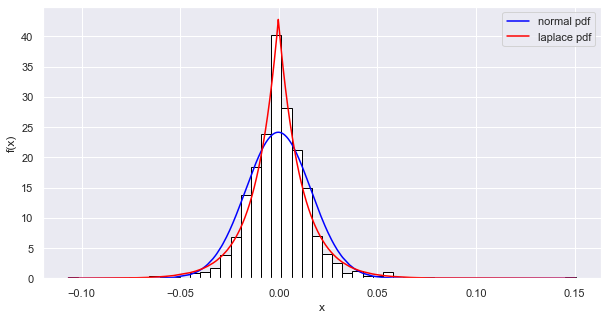

In [91]:
norm_kde(r2, laplace)

In [92]:
comp_quantile(r2, .95, .975, .99)

,p,real,normal,logistic
0,95.00%,0.023344,0.026907,0.026552
1,97.50%,0.031319,0.032115,0.033104
2,99.00%,0.050773,0.038170,0.041592


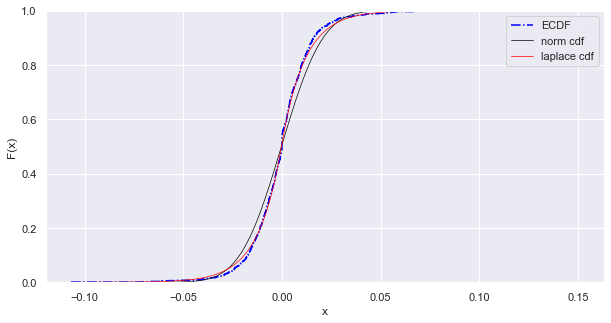

In [93]:
cdf(r2, laplace)

In [94]:
comp_dist(r)

,x0,normal,logistic
0,-0.05,0.000242,0.029613
1,-0.03,0.018441,0.110361
2,-0.01,0.246792,0.335231
3,0.00,0.506622,0.504150
4,0.01,0.763565,0.672126
5,0.03,0.983008,0.892857
6,0.05,0.999786,0.971327


# PRZYPADEK WIELOWYMIAROWY

In [95]:
idx = 952 #liczone przy aluminium

In [96]:
stock1 = copper['Open'].values[:idx][::-1]
stock2 = aluminium['Open'].values[:idx][::-1]

In [97]:
s = np.array(stock1[1:])
s2 = np.array(stock1[:-1])
r1 = np.log(s/s2)

In [98]:
s_ = np.array(stock2[1:])
s2_ = np.array(stock2[:-1])
r2 =  np.log(s_/s2_)

## Wykres wartości portfela (to jest źle - nie brać tego!)

In [99]:
#funkcja tworzy portfel z dwóch zmiennych ryzyka - w1 i w2 to wagi portfela
def portfolio(x1, x2, w1, w2):
    try:
        x = w1*x1 + w2*x2
    except ValueError:
        print('Rozmiary próbek muszą być równe!')
    return x
        

In [100]:
port = portfolio(r1, r2, 1/3, 2/3)

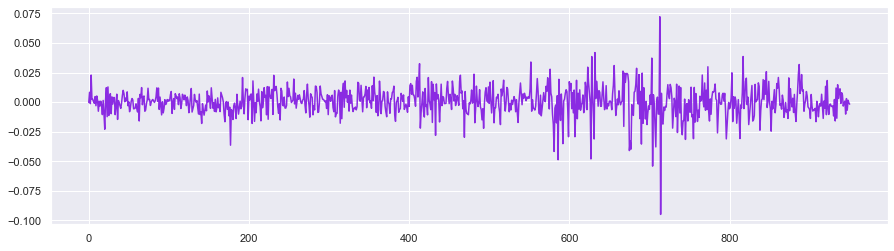

In [101]:
fig, ax = plt.subplots(figsize = (15, 4))
plt.plot(port, color = 'blueviolet')
plt.show()

## Dwuwymiarowy rozkład empiryczny zwrotów logarytmicznych

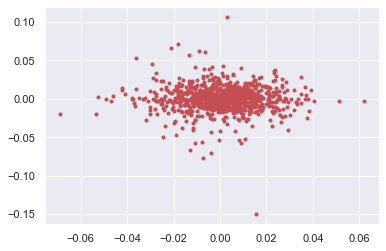

In [102]:
plt.plot(r1, r2, '.r')
plt.show()

In [103]:
corr = np.corrcoef(r1, r2)
print('Korelacja Pearsona: ' + str(corr))

Korelacja Pearsona: [[ 1.         -0.02699923]
 [-0.02699923  1.        ]]


Text(0, 0.5, '')

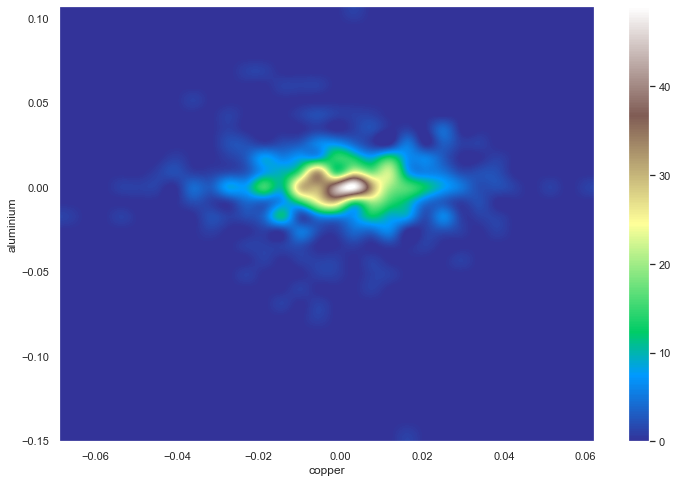

In [104]:
heatmap, xedges, yedges = np.histogram2d(r1, r2, bins = 30)

fig = plt.figure(figsize = (12, 8))
plt.imshow(heatmap.T, interpolation="spline36", 
               cmap = 'terrain',
              extent = [min(xedges), max(xedges),
                       min(yedges), max(yedges)],
          aspect = 'auto',
          origin = 'lower')
plt.grid(visible = False)
plt.xlabel('copper')
plt.ylabel('aluminium')
cbar = plt.colorbar()
cbar.ax.set_ylabel('')

## Dystrybuanta zwrotów log portfela

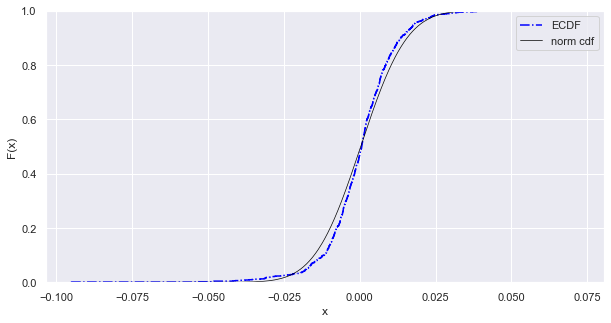

In [105]:
cdf(port, True)

## Dystrybuanta 2d

In [106]:
def cdf_2d(x, y):
    try:
        heatmap = np.zeros((len(x), len(y)))
        x_ = np.linspace(min(x), max(x), len(x))
        y_ = np.linspace(min(y), max(y), len(y))
        for i in range(len(x)):
            for j in range(len(y)):
                heatmap[i][j] = len(x[x < x_[i]])/len(x)*len(y[y < y_[j]])/len(y)
        fig = plt.figure(figsize = (12, 8))
        plt.imshow(heatmap.T, interpolation="spline36", 
                       cmap = 'Greens',
                      extent = [min(x), max(x),
                               min(y), max(y)],
                  aspect = 'auto',
                  origin = 'lower')
        plt.grid(visible = False)
        plt.xlabel('copper')
        plt.ylabel('aluminium')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('')
        plt.show()
    except ValueError:
        print('Różne rozmiary prób!')

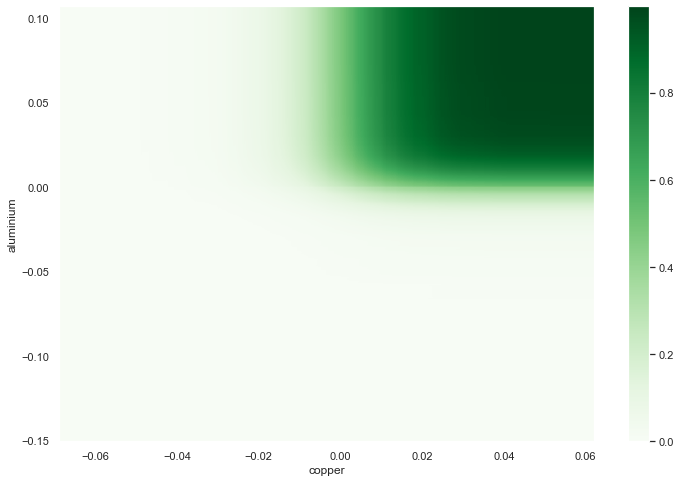

In [107]:
cdf_2d(r1, r2)

# Rozkład maksimów

In [135]:
copper_10y = pd.read_csv('../data/copper10yrs.csv')

Y = np.array(copper_10y.Open.values[::-1])
X = np.log(Y[1:] / Y[:-1])
X = X[X > 0]

n = 126
ksi = 0.07568019006684479
mu = 0.02144249900604158
sigma = 0.008213164153487319


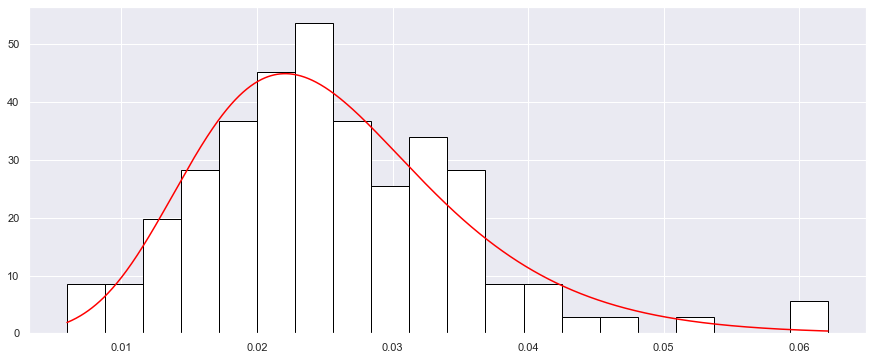

In [126]:
L = []
step = 10
i = step
while i < len(X) + 1:
    L.append(max(X[i-step:i]))
    i += step
print('n =', len(L))

ksi, mu, sigma = sp.genextreme.fit(L)
print('ksi =', ksi)
print('mu =', mu)
print('sigma =', sigma)

plt.figure(figsize=(15, 6))
plt.hist(L, bins=20, density=True, color = 'white', ec = 'black')
xs = np.linspace(min(L), max(L), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi, mu, sigma), c='red')
plt.title('')
plt.show()

In [137]:
Y = np.array(aluminium2.Open.values[::-1])
X = np.log(Y[1:] / Y[:-1])
X = X[X > 0]
len(X)
len(Y)

952

n = 46
ksi = -0.2566022727570442
mu = 0.021359287947934964
sigma = 0.008716402453550754


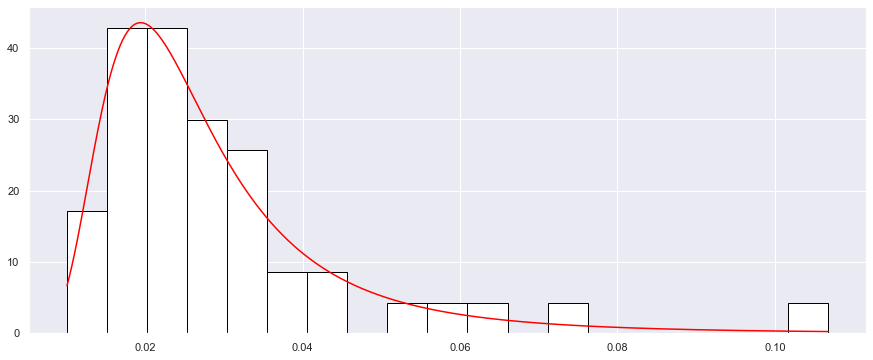

In [139]:
L = []
step = 10
i = step
while i < len(X) + 1:
    L.append(max(X[i-step:i]))
    i += step
print('n =', len(L))

ksi, mu, sigma = sp.genextreme.fit(L)
print('ksi =', ksi)
print('mu =', mu)
print('sigma =', sigma)

plt.figure(figsize=(15, 6))
plt.hist(L, bins=19, density=True, color = 'white', ec = 'black')
xs = np.linspace(min(L), max(L), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi, mu, sigma), c='red')
plt.show()